

**Credit: Artem Babchenko and Ekaterina Glazkova**

# UNet Model for the Image Segmentation Problem

In [5]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn

# Image Segmentation

Image segmentation is the task of classifying each pixel. For example, like this (example from the Cityscapes Dataset):

<img src="cityscapes_example.png" width="600" height="500">

In this notebook, it is proposed to implement the UNet model for two-class image segmentation.

In [6]:
from torch.optim.lr_scheduler import StepLR

from tqdm import trange

In [7]:
from hw2_util import WeizmannHorsesDataset, show_sample, plot_batch_with_results, plot_history, mean_accuracy, pixel_accuracy, mean_iou

### Downloading and reading data

We will use the Weizmann Horse dataset (source: http://www.msri.org/m/people/members/eranb/ section - Horse Images), consisting of black-and-white and color photographs of horses and markings for two class - foreground and background.

In [3]:
#! wget http://www.msri.org/people/members/eranb/weizmann_horse_db.tar.gz -O data.tar.gz
#! tar -xvzf data.tar.gz

In [8]:
data_path = "weizmann_horse_db" 
dataset = WeizmannHorsesDataset(data_path, "test", img_shape = (40,60), color = "rgb")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


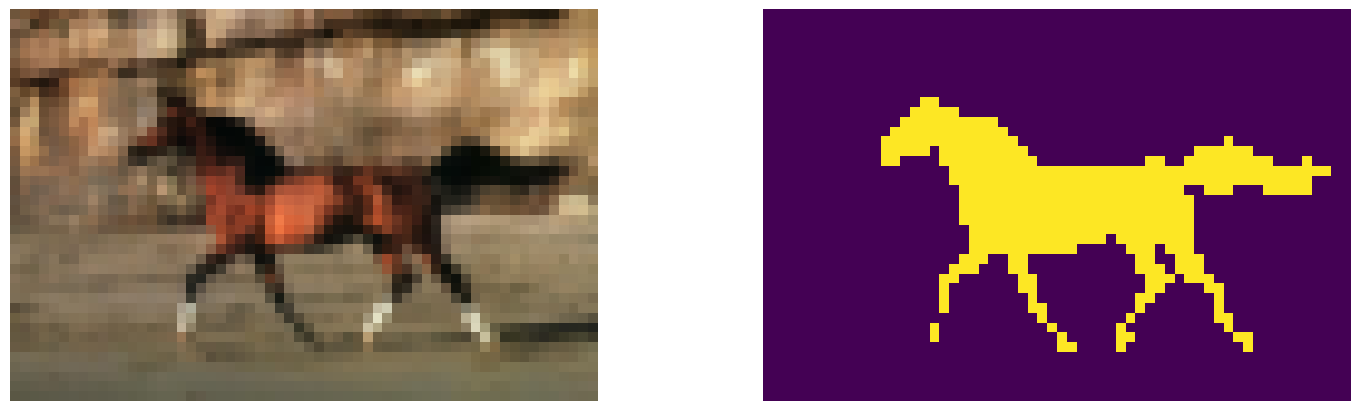

In [9]:
show_sample(dataset, 0)

## Model

UNet model schema from the original paper (https://arxiv.org/abs/1505.04597 ):

<img src="UNet.png" width="600" height="500">

In the image above, the blue boxes are feature maps.

The model receives the original image as input, the result of the model is the segmentation of the input image (classification of each pixel).

The model consists of an encoder (left in the diagram) and a decoder (right).

#### About implementation:

Several identical network layers processing the feature map without resizing (for example, repeating the Conv2d, BatchNorm2d, ReLU layers) are implemented in the **ConvBlock** class. In the image, one ConvBlock corresponds to several consecutive blue arrows.

In this implementation, you can not crop when copying the feature map, but use padding so that the sizes of the feature maps at the same decoder and encoder levels match.

To increase the size of the feature map when decoding (**UpBlock**), you may need nn.ConvTranspose2d or nn.Upsample.

In each next coding / decoding layer **DownBlock** / **UpBlock** it is supposed to decrease / increase x-y sizes by $ c_1 $ times and increase / decrease the number of channels by $ c_2 $ times. For example, you can take $ c_1 = c_2 = 2 $.

In [75]:
import torch.nn.functional as F
class ConvBlock(nn.Module):
    '''
       Convolutional Block, includes several sequential convolutional and activation layers.
       Hint: include BatchNorm here
    '''
    def __init__(self, input_ch, output_ch, kernel_size, block_depth):
        '''
            input_ch - input channels num
            output_ch - output channels num
            kernel_size - kernel size for convolution layers
            block_depth - number of convolution + activation repetitions
        '''
        super().__init__()
        
        # your code
        conv_list = []
        in_ch = input_ch
        for i in range(block_depth):
            out_ch = output_ch if i == block_depth-1 else in_ch
            conv_list += [nn.Conv2d(in_ch, out_ch, kernel_size, padding=kernel_size//2),
                          nn.BatchNorm2d(out_ch),
                          nn.ReLU(inplace=True)]
            in_ch = out_ch

        self.conv_net = nn.Sequential(*conv_list)

    def forward(self, x):
        x = self.conv_net(x)
        return x
    
    
class DownBlock(nn.Module):
    '''
        Encoding block, includes pooling (for shape reduction) and Convolutional Block (ConvBlock)
    '''
    def __init__(self, input_ch, output_ch, kernel_size, block_depth):
        super().__init__()
        
        # your code
        self.layers = nn.Sequential(
            ConvBlock(input_ch, output_ch, kernel_size, block_depth),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class UpBlock(nn.Module):
    '''
        Decoding block, includes upsampling and Convolutional Block (ConvBlock)
    '''
    def __init__(self, input_ch, output_ch, kernel_size, block_depth):
        super().__init__()
        
        # your code
        # Upsampling layer
        self.upsample = nn.ConvTranspose2d(input_ch, input_ch // 2, kernel_size=2, stride=2)
        
        # Convolutional block
        self.conv_block = ConvBlock(input_ch, output_ch, kernel_size, block_depth)
        

    def forward(self, copied_input, lower_input):
        '''
            copied_input - feature map from one of the encoder layers
            lower_input - feature map from previous decoder layer
        '''
        # your code
        #print('before upsample')
        #print(copied_input.shape)
        #print(lower_input.shape)
        
        # Upsample the copied input to match the shape of the lower input
        x = self.upsample(copied_input)
        #print('before pad')
        #print(x.shape)
        #print(lower_input.shape)
        
        a=0
        b=0
        
        # Pad the upsampled feature map from encoder to match the shape of the lower input
        if x.size(2)<lower_input.size(2):
            b = 1
        if x.size(3)<lower_input.size(3):
            a = 1
            
        x = F.pad(x, pad=(a, 0, b, 0))
        
        #print(a,b)
        
        # Concatenate the upsampled copied input with the lower input
        #print('after pad')
        #print(x.shape)
        #print(lower_input.shape)
        x = torch.cat([x, lower_input], dim=1)
        
        # Apply the convolutional block to the concatenated feature maps
        x = self.conv_block(x)
        
        
        return x


In [65]:
class UNet(nn.Module):
    def __init__(self, n_classes, feature_levels_num, input_ch_size, hidden_ch_size, block_depth, kernel_size = 3):
        """
        Input:
            n_classes - number of classes
            feature_levels_num - number of down- and up- block levels
            input_ch_size - input number of channels (1 for gray images, 3 for rgb)
            hidden_ch_size - output number of channels of the first Convolutional Block (in the original paper - 32)
            block_depth - number of convolutions + activations in one Convolutional Block
            kernel_size - kernel size for all convolution layers
        """
        super(UNet, self).__init__()
        self.input_block = ConvBlock(input_ch_size, hidden_ch_size, 1, block_depth)
        self.down_blocks = []
        self.up_blocks = []
        self.feature_levels_num = feature_levels_num
        
        
        cur_ch_num = hidden_ch_size
        for _ in range(feature_levels_num):
            # your code
            # fill self.down_blocks and self.up_blocks with DownBlock/UpBlock
            # each DownBlock/UpBlock increase/decrease number of channels by 2 times
            down_block = DownBlock(cur_ch_num, cur_ch_num * 2, kernel_size, block_depth)
            up_block = UpBlock(cur_ch_num * 2, cur_ch_num, kernel_size, block_depth)
            self.down_blocks.append(down_block)
            self.up_blocks.append(up_block)
            cur_ch_num *= 2
            
        
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)
        self.output_block = ConvBlock(hidden_ch_size, n_classes, 1, block_depth)

    def forward(self, x):
        x = self.input_block(x)
        
        # your code
        skip_connections = []
        for down_block in self.down_blocks:
            skip_connections.append(x)
            x = down_block(x)

        x = self.up_blocks[-1](x, skip_connections[-1])
        for i in range(len(self.up_blocks) - 2, -1, -1):
            x = self.up_blocks[i](x, skip_connections[i])
        
        x = self.output_block(x)
        return x  

## Quality of prediciton

For segmentation of an image of size $ H\times W $ into a set of classes $ C $, the following metrics can be considered:

$$Mean~IoU = \frac{1}{|C|}\sum_{i \in C}\frac{TP_i}{FP_i + TP_i + FN_i}$$

$$Pixel~Accuracy = \frac{\sum_{i \in C}TP_i}{H\times W}$$

$$Mean~Accuracy = \sum_{i \in C}\frac{TP_i}{TP_i + FN_i}$$

## Learning

In [24]:
from collections import defaultdict

In [25]:
def train_epoch(model, optimizer, train_loader):
    loss_log = []
    model.train()
    for _, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):
        optimizer.zero_grad()
        prediction = model(x_batch)
        loss = nn.CrossEntropyLoss()(prediction, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    return loss_log

def test(model, test_loader, train_loader):
    '''
        Computes metrics on both train and test, loss on test
    '''
    history = defaultdict(list)
    model.eval()
    
    for batch_num, (x_batch, y_batch) in zip(trange(len(test_loader)), test_loader):
        pred = model(x_batch)
        ce_loss = nn.CrossEntropyLoss()(pred, y_batch.squeeze()).item()
        pred = torch.argmax(pred, dim = 1) #before: (bs, classes, h, w)
        iou_sum = 0
        pixel_acc_sum = 0
        mean_acc_sum = 0
        for i in range(x_batch.shape[0]):
            iou_sum += mean_iou(pred[i].cpu().squeeze(), y_batch[i].cpu().squeeze())
            pixel_acc_sum += pixel_accuracy(pred[i].cpu().squeeze(), y_batch[i].cpu().squeeze())
            mean_acc_sum += mean_accuracy(pred[i].cpu().squeeze(), y_batch[i].cpu().squeeze())
            
        history["loss_val"].append(ce_loss)
        history["iou_val"].append(iou_sum/x_batch.shape[0])
        history["pixel_acc_val"].append(pixel_acc_sum/x_batch.shape[0])
        history["mean_acc_val"].append(mean_acc_sum/x_batch.shape[0])
        
        if batch_num == 0:
            plot_batch_with_results(x_batch.cpu(), y_batch.cpu(), pred.cpu()) 
            
    for batch_num, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):  
        pred = torch.argmax(model(x_batch), dim = 1)
        iou_sum = 0
        pixel_acc_sum = 0
        mean_acc_sum = 0
        for i in range(x_batch.shape[0]):
            pred_squeezed = pred[i].squeeze()
            y_squeezed = y_batch[i].squeeze()
            iou_sum += mean_iou(pred_squeezed, y_squeezed)
            pixel_acc_sum += pixel_accuracy(pred_squeezed, y_squeezed)
            mean_acc_sum += mean_accuracy(pred_squeezed, y_squeezed)
        
        history["iou_train"].append(iou_sum/x_batch.shape[0])
        history["pixel_acc_train"].append(pixel_acc_sum/x_batch.shape[0])
        history["mean_acc_train"].append(mean_acc_sum/x_batch.shape[0])

    return history
    
def train_procedure(model, opt, n_epochs, train_loader, test_loader, scheduler):
    history = defaultdict(list)
    steps = len(train_loader)

    for epoch in range(n_epochs):
        
        train_loss = train_epoch(model, opt, train_loader)
        test_history = test(model, test_loader, train_loader)
        
        history["loss_train"].extend(train_loss)
        history["loss_val"].append((steps * (epoch + 1), np.mean(test_history["loss_val"])))
        
        for key in test_history:
            if (key != "loss_val"):
                history[key].append(np.mean(test_history[key]))
                
        plot_history(history)
        
        print("Epoch average loss:", np.mean(train_loss))
        print("Epoch validation metrics:")
        print("\tIoU -", history['iou_val'][-1])
        print("\tmean accuracy -", history['mean_acc_val'][-1])
        print("\tpixel acc -", history["pixel_acc_val"][-1])

Select the network parameters, train the model. If done correctly, the final IoU should be greater than 0.8.

In [71]:
#your parameters
n_classes = 2
shape = (40,60)
input_ch_size = 3
hidden_ch_size = 16
feature_levels_num = 5
block_depth = 2

batch_size = 8
n_epochs = 25
lr = 0.05
lr_step = 10 
lr_gamma = 0.5

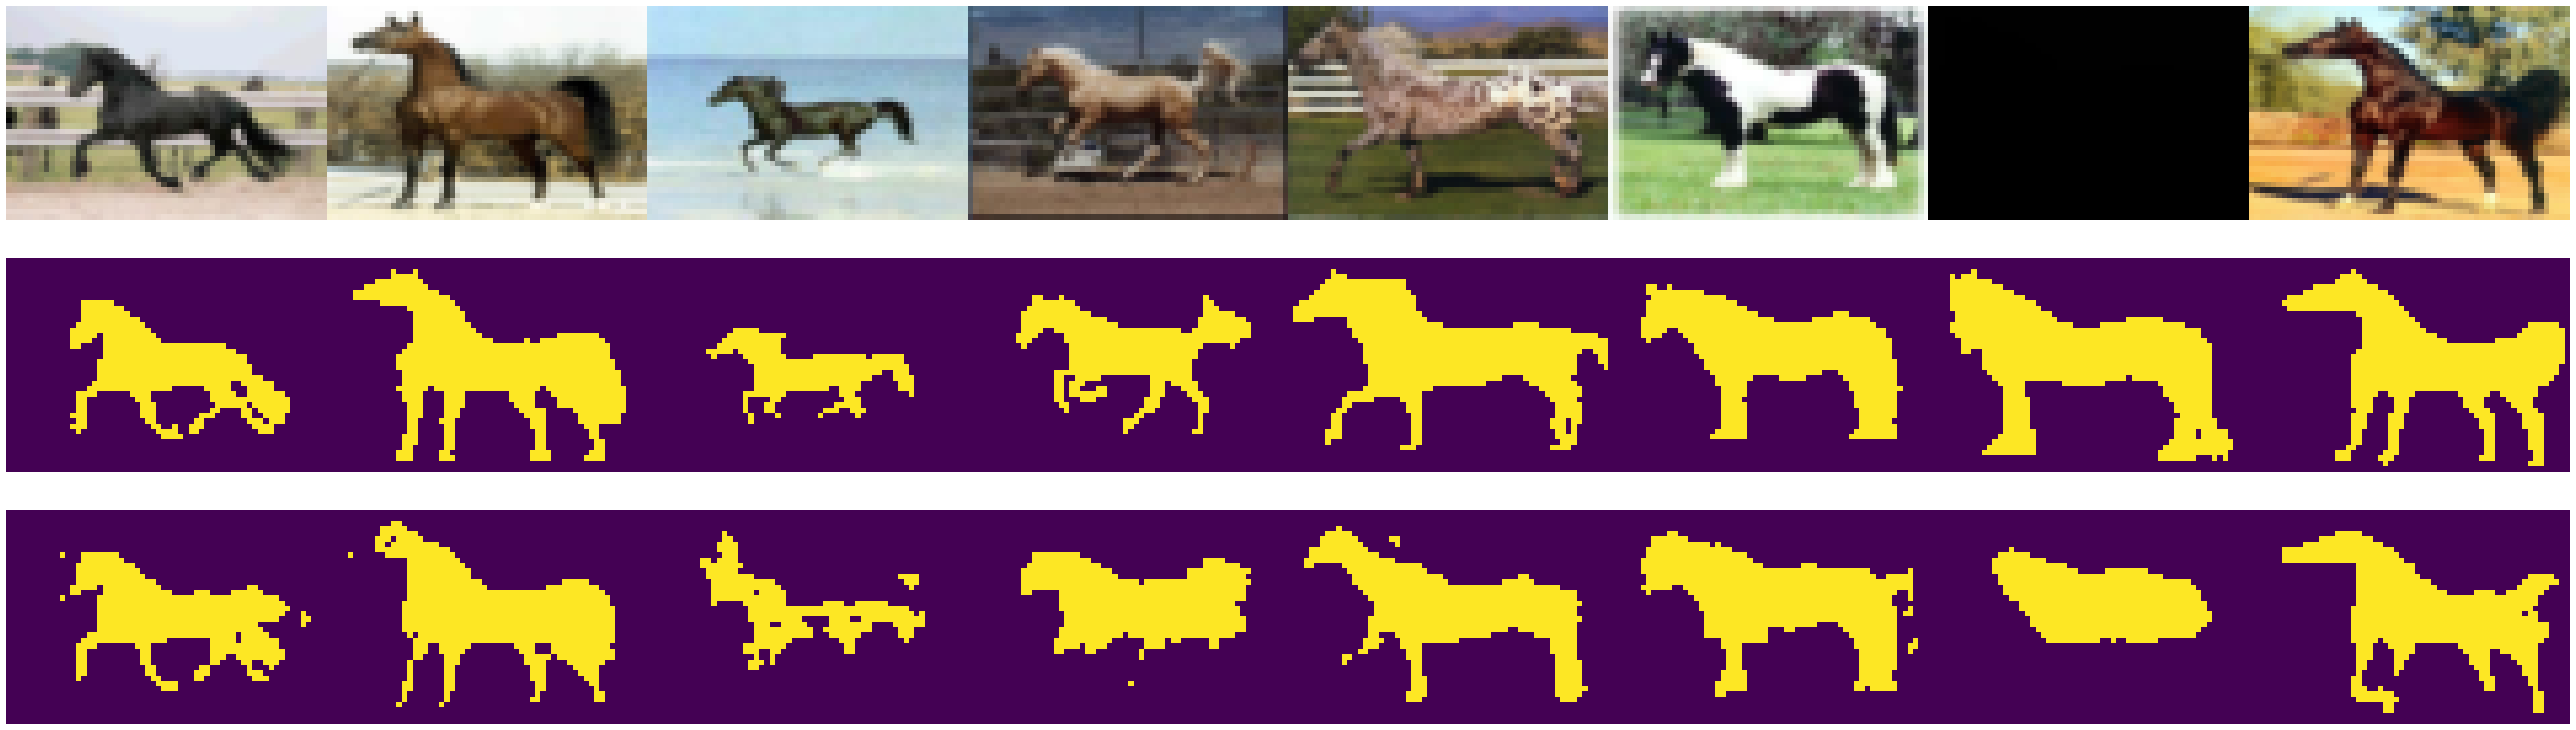

100%|███████████████████████████████████████████| 33/33 [00:05<00:00,  6.18it/s]


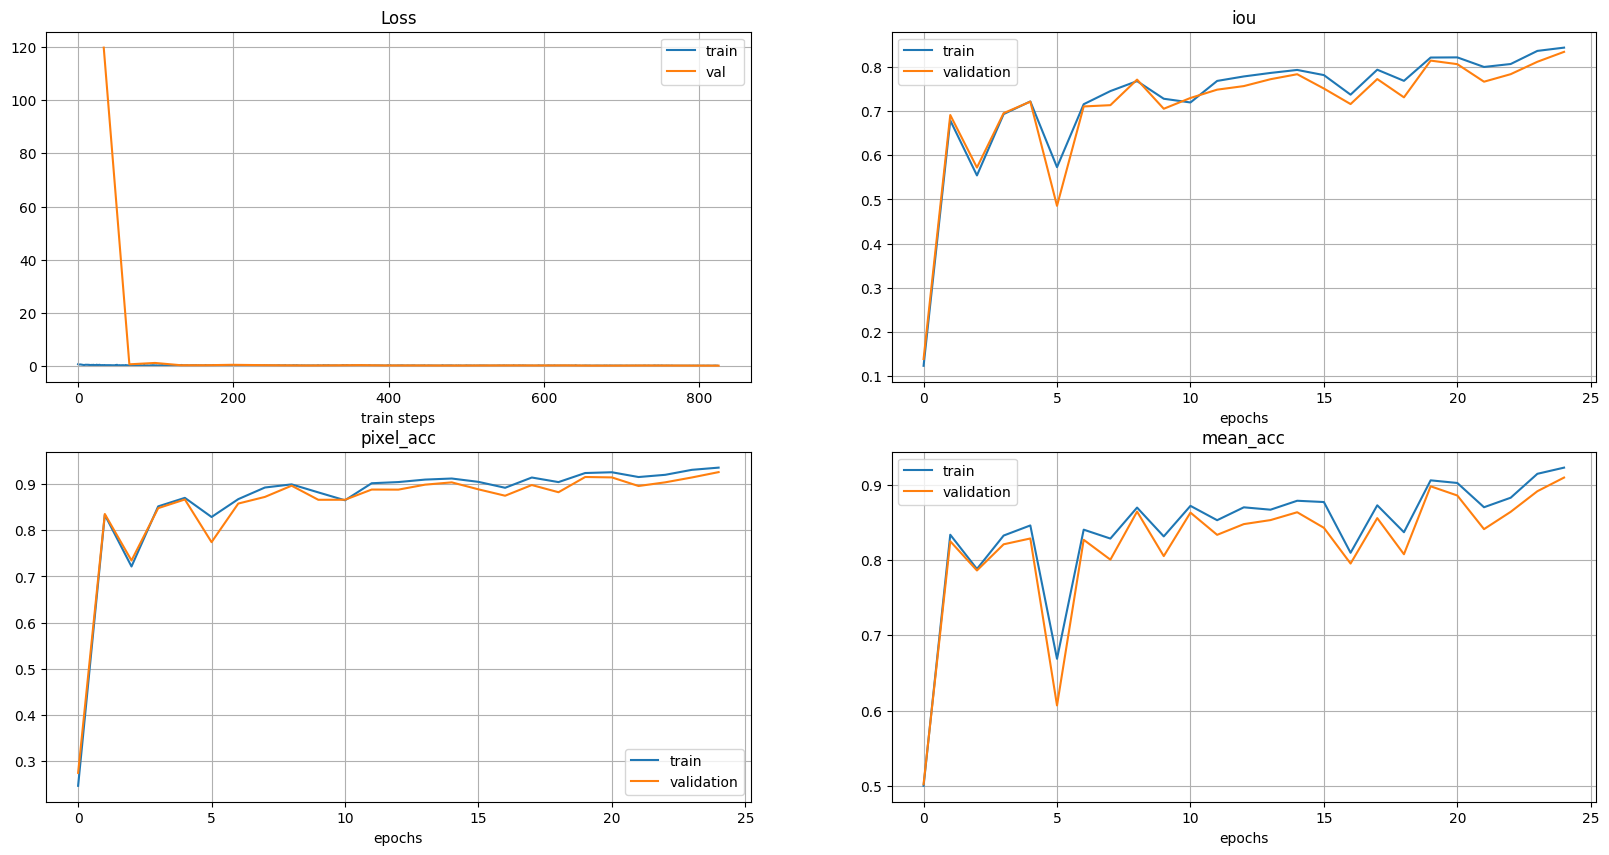

Epoch average loss: 0.15884212110981796
Epoch validation metrics:
	IoU - 0.83427304
	mean accuracy - 0.9098253
	pixel acc - 0.9262269


In [76]:
train_dataset = WeizmannHorsesDataset(root=data_path, split="train", img_shape = shape)
test_dataset = WeizmannHorsesDataset(root=data_path, split="val", img_shape = shape)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = True)

model = UNet(n_classes, feature_levels_num, input_ch_size, hidden_ch_size, block_depth)

opt = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(opt, step_size=lr_step, gamma=lr_gamma)
train_procedure(model, opt, n_epochs, train_loader, test_loader, scheduler = scheduler)